In [1]:
import numpy as np
import awkward as ak
import hist
import warnings
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc
import math

In [2]:
warnings.filterwarnings('ignore', 'No format checks')

In [3]:
def signal_read_in(signal_name, msd_up, msd_down, pt_up, pt_down):
    signal = ak.from_parquet(f'/scratch365/cmoore24/training/data/no_subcut/{signal_name}.parquet')
    signal = signal[signal['FatJets.msoftdrop'] < msd_up]
    signal = signal[signal['FatJets.msoftdrop'] > msd_down]
    signal = signal[signal['FatJets.pt'] < pt_up]
    signal = signal[signal['FatJets.pt'] > pt_down]
    signal['FatJets.mratio'] = signal['FatJets.mass']/signal['FatJets.msoftdrop']
    model = model = f'models_and_scalers/qcd/{signal_name}_nosubcut_traced_model.pt'
    with open(f'models_and_scalers/qcd/{signal_name}_nosubcut_scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)
    return signal, model, scaler

In [4]:
msd_up = 200
msd_down = 40
pt_up = 600
pt_down = 450

In [5]:
#use = 'hbb'
use = 'hgg'
if use == 'hgg':
    signal, model, scaler = signal_read_in('hgg', msd_up, msd_down, pt_up, pt_down)
else:
    signal, model, scaler = signal_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [6]:
def bkg_read_in(bkg_name, msd_up, msd_down, pt_up, pt_down):
    bkg = ak.from_parquet(f'/scratch365/cmoore24/training/data/no_subcut/{bkg_name}.parquet')
    bkg = bkg[bkg['FatJets.msoftdrop'] < msd_up]
    bkg = bkg[bkg['FatJets.msoftdrop'] > msd_down]
    bkg = bkg[bkg['FatJets.pt'] < pt_up]
    bkg = bkg[bkg['FatJets.pt'] > pt_down]
    bkg['FatJets.mratio'] = bkg['FatJets.mass']/bkg['FatJets.msoftdrop']
    return bkg

In [7]:
bkg_dict = {}
bkg_dict['qcd'] = bkg_read_in('qcd', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ttboosted'] = bkg_read_in('ttboosted', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wqq'] = bkg_read_in('wqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zqq'] = bkg_read_in('zqq', msd_up, msd_down, pt_up, pt_down)
bkg_dict['singletop'] = bkg_read_in('singletop', msd_up, msd_down, pt_up, pt_down)
bkg_dict['ww'] = bkg_read_in('ww', msd_up, msd_down, pt_up, pt_down)
bkg_dict['wz'] = bkg_read_in('wz', msd_up, msd_down, pt_up, pt_down)
bkg_dict['zz'] = bkg_read_in('zz', msd_up, msd_down, pt_up, pt_down)
if use == 'hgg':
    bkg_dict['hbb'] = bkg_read_in('hbb', msd_up, msd_down, pt_up, pt_down)

In [8]:
class EnergyCorrelatorFunctionTagger(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                'n2b1': fatjets['FatJets.n2b1'],
                'n3b1': fatjets['FatJets.n3b1'],
                'nConstituents': fatjets['FatJets.nConstituents'],
                #'color_ring': fatjets['FatJets.color_ring'],
                'd2b1': fatjets['FatJets.d2b1'],
                'u1': fatjets['FatJets.u1'],
                'u2': fatjets['FatJets.u2'],
                'u3': fatjets['FatJets.u3'],
                'd3': fatjets['FatJets.d3'],
                'm2': fatjets['FatJets.m2'],
                'm3': fatjets['FatJets.m3'],
                'n4': fatjets['FatJets.n4'],
                #'mratio': fatjets['FatJets.mratio'],
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [32]:
a = EnergyCorrelatorFunctionTagger(model)
sig_score = a(signal, scaler)[:,0]
qcd_score = a(bkg_dict['qcd'], scaler)[:,0]
wqq_score = a(bkg_dict['wqq'], scaler)[:,0]
zqq_score = a(bkg_dict['zqq'], scaler)[:,0]
ttboosted_score = a(bkg_dict['ttboosted'], scaler)[:,0]
singletop_score = a(bkg_dict['singletop'], scaler)[:,0]
ww_score = a(bkg_dict['ww'], scaler)[:,0]
wz_score = a(bkg_dict['wz'], scaler)[:,0]
zz_score = a(bkg_dict['zz'], scaler)[:,0]
if use == 'hgg':
    hbb_score = a(bkg_dict['hbb'], scaler)[:,0]
scores = {}
scores['sig'] = sig_score
scores['qcd'] = qcd_score
scores['wqq'] = wqq_score
scores['zqq'] = zqq_score
scores['ttboosted'] = ttboosted_score
scores['singletop'] = singletop_score
scores['ww'] = ww_score
scores['wz'] = wz_score
scores['zz'] = zz_score
if use == 'hgg':
    scores['hbb'] = hbb_score

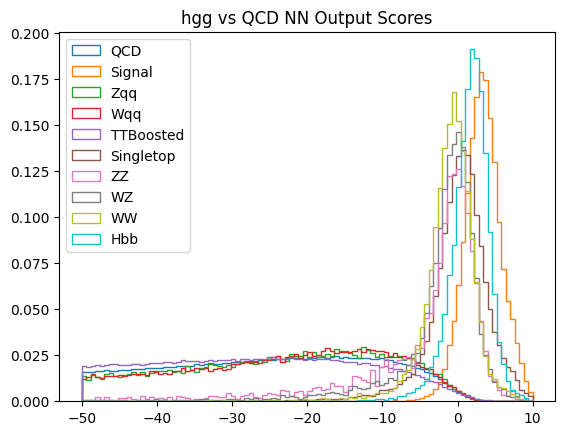

In [33]:
plt.hist(qcd_score, bins=100, range=(-50, 10), label='QCD', density=True, histtype='step')
plt.hist(sig_score, bins=100, range=(-50, 10), label='Signal', density=True, histtype='step')
plt.hist(zqq_score, bins=100, range=(-50, 10), label='Zqq', density=True, histtype='step')
plt.hist(wqq_score, bins=100, range=(-50, 10), label='Wqq', density=True, histtype='step')
plt.hist(ttboosted_score, bins=100, range=(-50, 10), label='TTBoosted', density=True, histtype='step')
plt.hist(singletop_score, bins=100, range=(-50, 10),  label='Singletop', density=True, histtype='step')
plt.hist(zz_score, bins=100, range=(-50, 10), label='ZZ', density=True, histtype='step')
plt.hist(wz_score, bins=100, range=(-50, 10), label='WZ', density=True, histtype='step')
plt.hist(ww_score, bins=100, range=(-50, 10), label='WW', density=True, histtype='step')
if use == 'hgg':
    plt.hist(hbb_score, bins=100, range=(-50, 10), label='Hbb', density=True, histtype='step')
plt.title(f'{use} vs QCD NN Output Scores')
plt.legend()
plt.show()

In [34]:
def msd_plotter(sample, sample_score, density, wp, fail):
    if fail:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score < wp]
        regime = 'Failing'
    else:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score > wp]
        regime = 'Passing'
    plt.hist(sample_cut_msd, range=(40,200), bins=30, density=density, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample]['FatJets.msoftdrop'], range=(40,200), bins=30, density=density, histtype='step', label=sample)
    plt.legend()
    if density:
        plt.title(f'Density Plot, {sample} With and Without NN Cut, {regime} WP = {wp}')
    else:
        plt.title(f'{sample} With and Without NN Cut, {regime} WP = {wp}')
    plt.show()

In [66]:
def msd_double_plotter(sample, sample_score, wp, fail):
    if fail:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score < wp]
        regime = 'Failing'
    else:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score > wp]
        regime = 'Passing'
    plt.figure(figsize=(20, 8), dpi=80)
    ax = plt.subplot(1, 2, 1)
    plt.hist(sample_cut_msd, range=(40,200), bins=30, density=True, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample]['FatJets.msoftdrop'], range=(40,200), bins=30, density=True, histtype='step', label=sample)
    plt.legend()
    plt.title(f'Density Plot, {sample} With and Without NN Cut, {regime} WP = {wp}')

    ax = plt.subplot(1, 2, 2)
    plt.hist(sample_cut_msd, range=(40,200), bins=30, density=False, histtype='step', label=f'NN Cut {sample}')
    plt.hist(bkg_dict[sample]['FatJets.msoftdrop'], range=(40,200), bins=30, density=False, histtype='step', label=sample)
    plt.legend()
    plt.title(f'{sample} With and Without NN Cut, {regime} WP = {wp}')

    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()

In [36]:
def make_hist(sample, sample_score):
    min = abs(math.floor(ak.min(sample_score)))
    max = math.ceil(ak.max(sample_score))
    bins = min + max
    score_hist = hist.Hist.new.Reg(bins, -min, max, name=f"NN_Score", label=f"{sample}_NN", overflow=False, underflow=False).Weight()
    score_hist.fill(NN_Score=sample_score)
    return score_hist

In [37]:
qcd_hist = make_hist('qcd', qcd_score)
hgg_hist = make_hist('hgg', sig_score)

In [38]:
ak.min(qcd_score), ak.max(qcd_score), ak.min(sig_score), ak.max(sig_score)

(-480.87912, 8.718506, -39.46598, 11.185974)

In [39]:
def roc_maker(signal_array, bkg_array, sig_score_hist, bkg_score_hist, sig_score, bkg_score, title, include_pn=False):
    bkg_zeros = ak.zeros_like(bkg_score)
    sig_ones = ak.ones_like(sig_score)
    combined = ak.concatenate([bkg_score,sig_score])
    combined_truth = ak.concatenate([bkg_zeros, sig_ones])

    bkg_total = bkg_score_hist[0:bkg_score_hist.size:sum]
    sig_total = sig_score_hist[0:sig_score_hist.size:sum]

    wp_dict = {}

    bkg_min = abs(int(bkg_score_hist.to_numpy()[1][0]))
    sig_min = abs(int(sig_score_hist.to_numpy()[1][0]))
    
    for i in range(-6, 8, 1):
        bkg_wp_value = bkg_score_hist[bkg_min+i:bkg_score_hist.size:sum]
        bkg_ratio = bkg_wp_value.value/bkg_total.value
    
        sig_wp_value = sig_score_hist[sig_min+i:sig_score_hist.size:sum]
        sig_ratio = sig_wp_value.value/sig_total.value
        wp_dict[i] = [sig_ratio, bkg_ratio]

    if include_pn:
        signal_array['FatJets.isSignal'] = np.ones_like(signal_array['FatJets.particleNetMD_QCD'])
        bkg_array['FatJets.isSignal'] = np.zeros_like(bkg_array['FatJets.particleNetMD_QCD'])
        arg1 = ak.concatenate([signal_array['FatJets.isSignal'], bkg_array['FatJets.isSignal']])
        arg2 = ak.concatenate([signal_array['FatJets.particleNetMD_QCD'], bkg_array['FatJets.particleNetMD_QCD']])  
        arg3 = ak.concatenate([signal_array['FatJets.particleNet_HbbvsQCD'], bkg_array['FatJets.particleNet_HbbvsQCD']])
        
        fpr2, tpr2, thresholds2 = roc_curve(arg1, arg2)
        fpr3, tpr3, thresholds3 = roc_curve(arg1, arg3)
        
        roc_auc2 = auc(tpr2, fpr2)
        roc_auc3 = auc(fpr3, tpr3)

    fig, ax = plt.subplots()
    fpr, tpr, thresholds = roc_curve(combined_truth, combined)
    roc_auc = auc(fpr, tpr)
    ax.set_yscale("log")
    ax.plot(tpr, fpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
    if include_pn:
        ax.plot(fpr2, tpr2, lw=2, color="red", label="PN_MD_QCD auc = %.3f" % (roc_auc2))
        ax.plot(tpr3, fpr3, lw=2, color="orange", label="PN_HbbvQCD auc = %.3f" % (roc_auc3))
    ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
    ax.set_xlim([0, 1.0])
    ax.set_ylim([1e-6, 1.0])
    ax.set_xlabel("true positive rate")
    ax.set_ylabel("false positive rate")
    ax.set_title(f"{title} ROC curve")

    for i in wp_dict:
        ax.plot(wp_dict[i][0], wp_dict[i][1], 'o', label=f'WP = {str(i)}')
    
    ax.axhline(y=1e-2, color='grey', linestyle='--')
    ax.axhline(y=1e-3, color='grey', linestyle='--')
    ax.axhline(y=1e-4, color='grey', linestyle='--')
    ax.axhline(y=1e-5, color='grey', linestyle='--')
    
    ax.legend(loc="lower right", bbox_to_anchor=(1.5, 0.4))
    
    plt.gcf().text(0.95, 0.3, f'{pt_down} < pt < {pt_up}', fontsize=14)
    plt.gcf().text(0.95, 0.2, f'{msd_down} < msd < {msd_up}', fontsize=14)
    plt.gcf().text(0.95, 0.1, '|η| < 2.4', fontsize=14)
    
    plt.show()

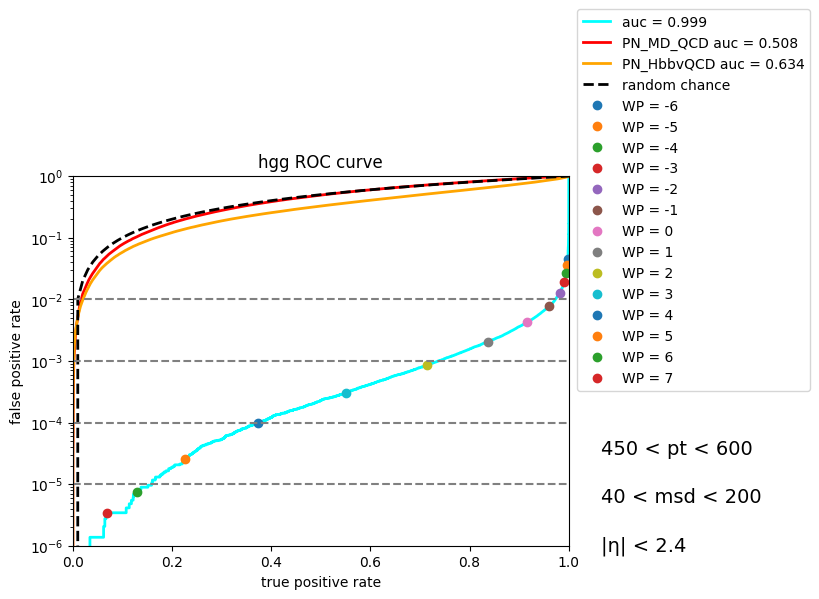

In [40]:
roc_maker(signal, bkg_dict['qcd'], hgg_hist, qcd_hist, sig_score, qcd_score, use, True)

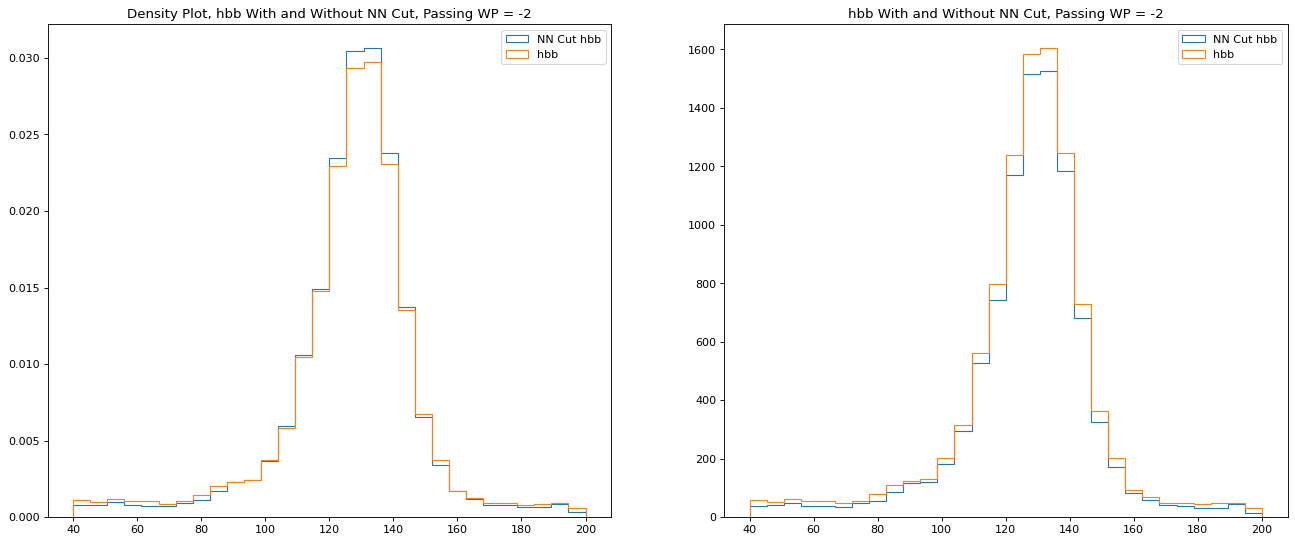

<Figure size 640x480 with 0 Axes>

In [67]:
msd_double_plotter('hbb', hbb_score, -2, False)

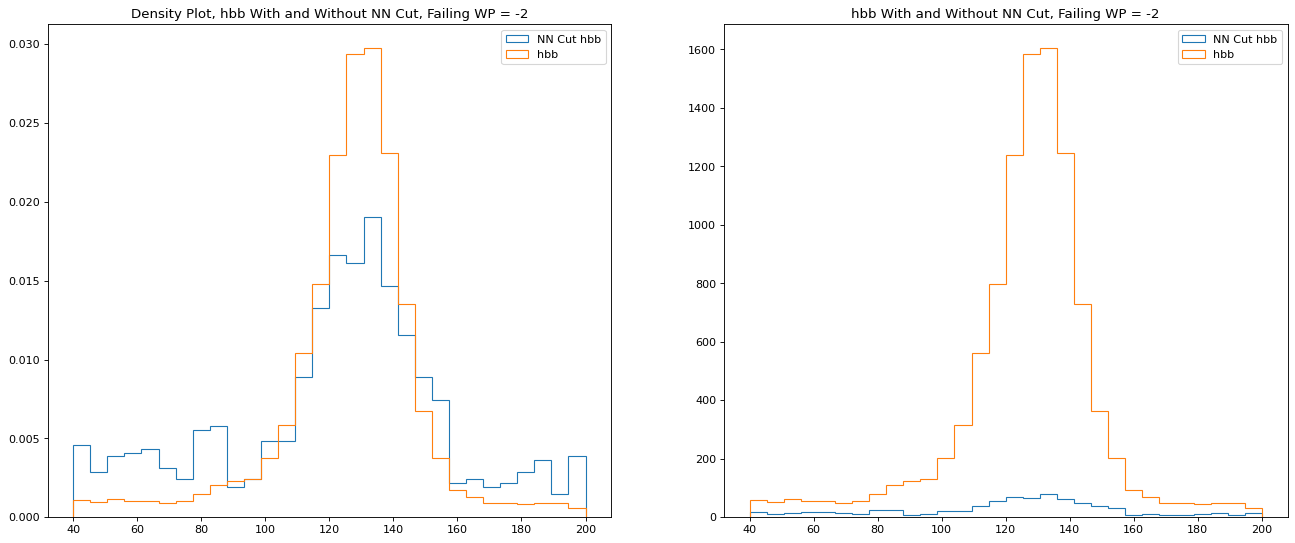

<Figure size 640x480 with 0 Axes>

In [68]:
msd_double_plotter('hbb', hbb_score, -2, True)

In [51]:
def bkg_output_hist(sample, sample_score, wp, fail):
    if fail:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score < wp]
    else:
        sample_cut_msd = bkg_dict[sample]['FatJets.msoftdrop'][sample_score > wp]
    msd_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"SoftDrop_Mass", label=f"{sample} MSD").Weight()
    msd_hist.fill(SoftDrop_Mass=sample_cut_msd)
    return msd_hist

In [48]:
for i in bkg_dict:
    msd_hist = bkg_output_hist(i, scores[i], wp=-2, fail=False)
    with open(f'output_hists/pass/{use}_vs_{i}_pass_wp_neg2.pkl', 'wb') as f:
        pickle.dump(msd_hist, f)

In [49]:
for i in bkg_dict:
    msd_hist = bkg_output_hist(i, scores[i], wp=-2, fail=True)
    with open(f'output_hists/fail/{use}_vs_{i}_fail_wp_neg2.pkl', 'wb') as f:
        pickle.dump(msd_hist, f)

In [62]:
sample_cut_msd = signal['FatJets.msoftdrop'][sig_score < -2]
sig_fail_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"SoftDrop_Mass", label=f"{use} MSD").Weight()
sig_fail_hist.fill(SoftDrop_Mass=sample_cut_msd)
with open(f'output_hists/fail/{use}_fail_wp_neg2.pkl', 'wb') as f:
    pickle.dump(msd_hist, f)

In [63]:
sample_cut_msd = signal['FatJets.msoftdrop'][sig_score > -2]
sig_pass_hist = hist.Hist.new.Reg(40, msd_down, msd_up, name=f"SoftDrop_Mass", label=f"{use} MSD").Weight()
sig_pass_hist.fill(SoftDrop_Mass=sample_cut_msd)
with open(f'output_hists/pass/{use}_pass_wp_neg2.pkl', 'wb') as f:
    pickle.dump(msd_hist, f)

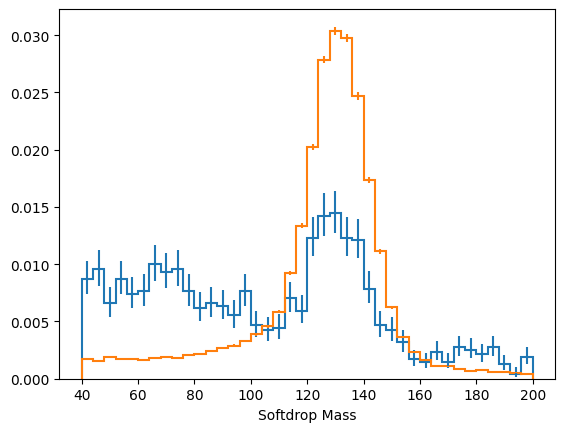

In [70]:
fig, ax = plt.subplots()
sig_fail_hist.plot1d(density=True)
sig_pass_hist.plot1d(density=True)
plt.xlabel('Softdrop Mass')
plt.show()